In [1]:
%%html
<link rel="stylesheet" href="static/hyrule.css" type="text/css">

# Feature Selection and Feature Reduction

## Objectives

* Review core concepts around why when and how to select features
* Using machine learning models to decide features to keep
* How data transformations like PCA reduce your data but maintain variance

## Class Notes

We'll primarily be concerned with two sklearn modules today: 

* A deeper dive into [feature_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)
* Exploring use cases for [dimensionality reduction](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)

### What makes a good feature?

In the effort of simplicity and generality, good, strong features can be described to have the following attributes:

* **high variance**: a feature with only one value is significantly less useful than one with many values
* **correlation**: a positive or negative relationship with a target variable; low correlation suggests a lack of that relationship. (Keep in mind that correlation doesn't always mean causation either)
* **predictive power**: features with large coefficients and importances are great; features with close to 0 coefficients, not so great

### What makes a good model?

* **good features!**
* and.... **simplicity**

<img src='img/overfitting.png' />
_while we haven't used polynomials, there's still a balance for our models between simplicity and feature dependence_

#### Why?
We should aim to keep our models as simple as possible in order to attribute the most gain.  
Simple models are much easier to understand as well

### How do we reduce the number of features in our data?

There's a number of techniques available in sklearn that automate these processes for us:

sklearn_helper | technique
---------------|----------
`VarianceThreshold` | Remove features with low variance, based on a tolerance level
`SelectKBest` | Select the best group of correlated features using `feature_selection` tools. K (as usual) is something you search for and define.
`L1 and Trees` | using fit_transform on any supervised learning algorithm that has it can drop features with low coefficients or importances.

While SKlearn also has a `pipeline` module to _further_ automate this process for you, it is more recommended to explore the data first to get a sense of what you are working with. There's no magic button that says "solve my problem," but if you are interested in automating a model fit (say, a nightly procedue on a deployed model with constantly updated data), then it might be something worth exploring. 

For each below we'll work through Iris and notice how it picks out the best features for us. We'll use iris because the data is well scaled (which otherwise requires finetuning) and relatively predictive (we know there are features more predictive than others).

For each code sample below:

1. Review what the code is doing. Consider opening up the help function or reading the documentation on sklearn.
2. find the `.shape` of the new array returned and compare to the original dataset. What columns did it end up keeping, vs removing?
3. Adjust the parameters. Do results change?
4. ** \* **These are all considered data preprocessing steps. In your final project, what and where might you consider adding one of these processes?

In [2]:
import pandas as pd
def make_irisdf():
    from sklearn.datasets import load_iris
    from pandas import DataFrame
    iris = load_iris()
    df = DataFrame(iris.data, columns=iris.feature_names)
    df['target'] = iris.target
    return df

iris = make_irisdf()

In [3]:
from sklearn import feature_selection

#### `VarianceThreshold`

Goals:

1. What is variance?
2. How does changing the threshold change the fit_transform?

In [4]:
print iris.ix[:,:4].apply(lambda x: x.var())
print iris.ix[:,:4].head()
print feature_selection.VarianceThreshold(threshold=.6).fit_transform(iris.ix[:,:4])[:5]

sepal length (cm)    0.685694
sepal width (cm)     0.188004
petal length (cm)    3.113179
petal width (cm)     0.582414
dtype: float64
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
[[ 5.1  1.4]
 [ 4.9  1.4]
 [ 4.7  1.3]
 [ 4.6  1.5]
 [ 5.   1.4]]


#### `SelectKBest`
Goals:

1. while f test and chi2 are different tests, are the results the same?
2. How might you solve for k?

_math sidebar:_

$X^2 = \dfrac{(O-E)^2}{E}$<br />
O = observed frequencies<br />
E = expected frequencies<br />

In [5]:
print iris.ix[:,:4].head()
ftest = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=3)
print pd.Series(ftest.fit(iris.ix[:,:4], iris['target']).scores_, index=iris.ix[:,:4].columns)
print ftest.fit_transform(iris.ix[:,:4], iris['target'])[:5]

chi = feature_selection.SelectKBest(score_func=feature_selection.chi2, k=3)
print pd.Series(chi.fit(iris.ix[:,:4], iris['target']).scores_, index=iris.ix[:,:4].columns)
print chi.fit_transform(iris.ix[:,:4], iris['target'])[:5]

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
sepal length (cm)     119.264502
sepal width (cm)       47.364461
petal length (cm)    1179.034328
petal width (cm)      959.324406
dtype: float64
[[ 5.1  1.4  0.2]
 [ 4.9  1.4  0.2]
 [ 4.7  1.3  0.2]
 [ 4.6  1.5  0.2]
 [ 5.   1.4  0.2]]
sepal length (cm)     10.817821
sepal width (cm)       3.594499
petal length (cm)    116.169847
petal width (cm)      67.244828
dtype: float64
[[ 5.1  1.4  0.2]
 [ 4.9  1.4  0.2]
 [ 4.7  1.3  0.2]
 [ 4.6  1.5  0.2]
 [ 5.   1.4  0.2]]


#### `LogisticRegression`
Goals:

1. How is L1 deciding to keep features?
2. How does changing C change the fit_transform results?

In [6]:
from sklearn import linear_model as lm
clf = lm.LogisticRegression(penalty='L1', C=0.1)
print iris.ix[:,:4].head()

print pd.DataFrame(clf.fit(iris.ix[:,:4], iris['target']).coef_, columns=iris.ix[:,:4].columns)
print clf.fit_transform(iris.ix[:,:4], iris['target'])[:5]

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.000000          1.124342          -1.344433                 0
1           0.000000         -0.386422           0.122768                 0
2          -0.987901          0.000000           1.277067                 0
[[ 3.5  1.4]
 [ 3.   1.4]
 [ 3.2  1.3]
 [ 3.1  1.5]
 [ 3.6  1.4]]


#### `DecisionTreeClassifier`
Goals:

1. What is Gini Importance?
2. How does fit_transform decide what features to keep?
3. How does changing the tree depth (or other preprocessing tools) change the result?

In [7]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=4)
print iris.ix[:,:4].head()
print pd.Series(clf.fit(iris.ix[:,:4], iris['target']).feature_importances_, index=iris.ix[:,:4].columns)
print clf.fit_transform(iris.ix[:,:4], iris['target'])[:5]

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
sepal length (cm)    0.013514
sepal width (cm)     0.000000
petal length (cm)    0.558165
petal width (cm)     0.428322
dtype: float64
[[ 0.2]
 [ 0.2]
 [ 0.2]
 [ 0.2]
 [ 0.2]]


### What if we believe there are hidden features in our data?
_I don't want to get rid of them!_

Then Principal Component Analysis to the rescue!

<!-- bah html coding! -->
<h3> What is principal component analysis? </h3>
<em>comparing how we measure residuals in regressions vs noise in pca</em>
<div style='text-align: center; margin: auto;'>
<img style='float: left;' src='img/ols.png' width='420' / >
<img style='float: left;' src='img/pca.jpg' width='420'/ >
</div>
<br style='clear: both;'/>
<div>
    <div style='float: left;'>
        <h3>Consider Broadway...</h3>
        <p>Manhattan is built on a grid system, with the exception of a couple key points:</p>
        <ul>
            <li>West Village (that's its own story)</li>
            <li>Broadway</li>
        </ul>
        <p>If we needed to get from Harold Square to Eataly, what is easier to explain?</p>
        <ol>
            <li>Walk down 6th avenue until 24th street and then walk east until the park</li>
            <li>Walk down Broadway until you get to Eataly at 24th</li>
        </ol>
        <p>Why is that one easier to explain?</p>
    </div>
    <div style='float: left;'>
        <img src='img/flatiron.png' width='310' />
    </div>
</div>
<br style='clear: both;'/>

### When should we use it?
PCA is a common technique already used in your day to day:

* compressing images or files
* Want to reduce computational expense
* Recognition (signal processing, speach, computer vision)
* Bioinformatics (microarray analysis)

<img src='img/pca_shakira.png' width='840' / >

### How does it work?

Recall that variance is a 1-dimensional metric describing the average distance from the mean. **Covariance** is a representation of variance with respect to other features.

If variance is a summary of one metric, and a correlation matrix is a square (the relationships of features against each other), what is our expected shape of the covariance matrix?

<img src='' />

We can intrepret the covariance matrix as:

* **diagonals**: the variance of given feature (the covariance of the feature compared to itself)
* **off-diagonals**: the covariance between two given features

Principal Component Analysis is, essentially, the _decomposition_ of the _covariance_ matrix. We are interested in finding the eigenvalues of a square matrix, which for our needs with PCA, represent the amount of variance explained in each principal component.

##### Technical Details: finding the decomposition of a square matrix
_here be demons_

Eigenvalues are defined as found so that:

$Av = \lambda v$

where $A$ is the original square matrix, lambda $\lambda$ is the _eigenvalue_ and $v$ is the _eigenvector_. 

We can rewrite this as:

$(A - \lambda I)v = 0$

where I is the identity matrix of shape A.

This then means, since we are finding a nonzero vector, that the determinant of $A - \lambda I$ must be 0. This solves our _eigenvalues_.

We can then find the eigenvectors given the shape A and determinants:

$\begin{bmatrix} a & b - \lambda \\ c - \lambda & d \end{bmatrix} * v = 0$

applying each _eigenvalue_ will find your _eigenvectors_.

#### Back to explaining Variance

So if the eigenvalues from the covariance matrix represent some value of how much variance each component explains (and in order from most to least)... how do we decide how much to keep?

What does this remind us of?

#### Examples

Let's walk through a few examples of decomposition with random data. We'll start with data where we expect the covariance values to be the same as the variance of each feature. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
random_data = pd.DataFrame({
        'x': range(1, 10),
        'y': range(1, 10),
        'z': range(1, 10),
    })
print np.cov(random_data.T, bias=1)

print np.var(random_data.x.T)

[[ 6.66666667  6.66666667  6.66666667]
 [ 6.66666667  6.66666667  6.66666667]
 [ 6.66666667  6.66666667  6.66666667]]
6.66666666667


Next, we want to pull out the eigenvalues and eigenvectors:

In [9]:
eig, Q = np.linalg.eig(np.cov(random_data.T, bias=1))
# sort for largest eigenvalue
print eig
print Q

[  1.77635684e-15   2.00000000e+01   0.00000000e+00]
[[-0.81649658  0.57735027  0.        ]
 [ 0.40824829  0.57735027 -0.70710678]
 [ 0.40824829  0.57735027  0.70710678]]


#### How do we evaluate the performance of it?

1. **It's linear.**
2. Principal Components are sorted from most explanatory to least explanatory
3. We want to maximize the variance explained, and cut off the least informative part
4. What did we learn about that would help solve for this?

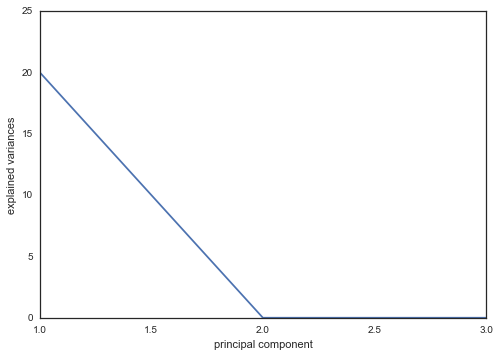

In [10]:
import seaborn as sns
from __future__ import division
eigsort = np.sort(eig)[::-1]
sns.set_style('white')
plt.figure()
plt.plot(range(1, len(eigsort) + 1), eigsort)
plt.xlabel('principal component')
plt.ylabel('explained variances')
plt.show()

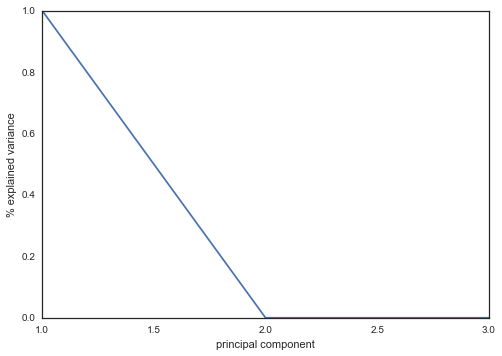

In [11]:
plt.figure()
plt.plot(range(1, len(eigsort) + 1), eigsort / sum(eigsort))
plt.xlabel('principal component')
plt.ylabel('% explained variance')
plt.show()

As we'd expect with the same data: PC1 will explain **all** of the variance in this data set, since all other features are literally the same. But what does this feature look like?

In [12]:
# ordering eigenvalues and vectors together
ordered = sorted(zip(eig, Q.T), reverse=True)
eig = np.array([_[0] for _ in ordered])
Q = np.column_stack((_[1] for _ in ordered))

# transforming data: We take the dot multiplication of the eigenvectors by the random data
X_transformed = np.dot(Q.T, random_data.T)
print X_transformed[0]

[  1.73205081   3.46410162   5.19615242   6.92820323   8.66025404
  10.39230485  12.12435565  13.85640646  15.58845727]


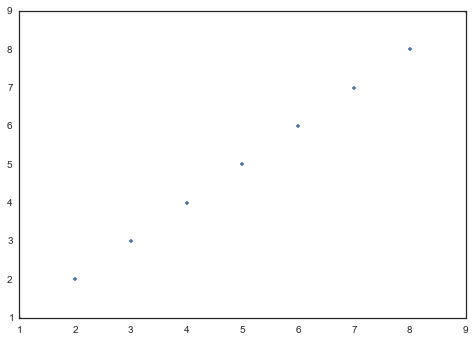

In [13]:
plt.figure()
plt.plot(random_data.y, random_data.x, '.')

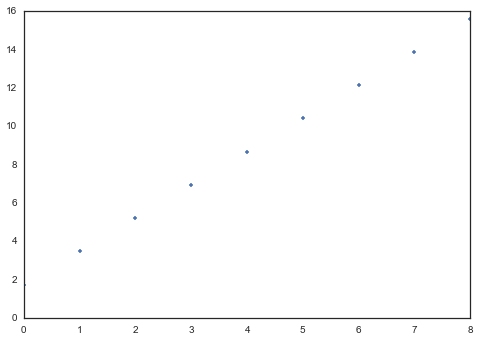

In [14]:
plt.figure()
plt.plot(X_transformed[0], '.')

And for sanity, let's compare our PC1 vs what sklearn would spit out.

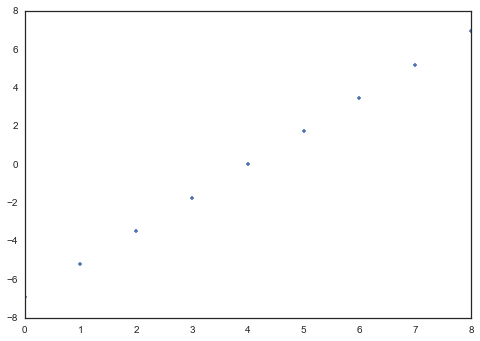

In [15]:
from sklearn import decomposition
plt.plot(decomposition.PCA().fit_transform(random_data).T[0], '.')

#### How do we explain it?

1. This isn't "made up data." We're using your original features to help explain the relationships.
2. Our shape is different because this is a _linear projection_ of our original data. It represents the same information, but is displayed differently.
3. Instead of using rules, we can use something else to explain relationships: correlations with the dependent variable.
4. Did we have features that were highly correlated? This may help us understand where our explained variances comes from.
5. The order of principal components is also related to the order of explained covariance; Therefore, PC1 would likely mostly be related to the features mostly correlated.

### Practice it!

What happens when we start introducing noise into our data? Run PCA on our new dataset below and evaluate what changes:

   x          y          z
0  1  -1.878842   6.794887
1  2  -8.625472  44.035247
2  3  26.777612  12.021532
3  4   6.347470  -4.309537
4  5  11.734814   5.665158


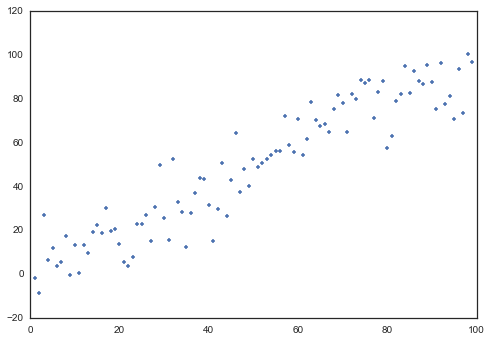

In [16]:
random_data_scattered = pd.DataFrame({
        'x': range(1, 100),
        'y': range(1, 100),
        'z': range(1, 100),
    })

random_data_scattered['y'] = random_data_scattered.y.apply(lambda y: y + np.random.normal(scale=10))
random_data_scattered['z'] = random_data_scattered.z.apply(lambda z: z + np.random.normal(scale=20))

print random_data_scattered.head()

plt.plot(random_data_scattered.x, random_data_scattered.y, '.')

1. Apply PCA to the above data using the PCA() class.
2. Evaluate the eigenvalues: how many principal components do we need?
3. Which feature[s] do the principal component[s] we keep explain?
4. Try:
    * changing the scatter on y and z,
    * adding more features with more scatter
    * adding scatter to x
    * with the iris data set:
        1. how many principal components do we need in this real data application?
        2. how do you "name" the new principal components? what do they explain?
    * with your own data set (where would this make sense?)    

#### What if we need a non linear solution?

PCA also allows for kernels, like SVMS, because sometimes we are not looking for a linear solution. The strategy and technique is the same. There's a sample script saved as `scripts/kernel_pca.py`, feel free to run the code and experiment.

## Review / Reading / Next Steps

* If you're unsure what is so "magical" about solving for eigenvectors and values, this [khan academy](https://www.khanacademy.org/math/linear-algebra/alternate_bases/eigen_everything/v/linear-algebra-introduction-to-eigenvalues-and-eigenvectors) set of videos is very informative!
* If you are looking for more detail, then [this paper](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) with included matlab code covers PCA from a very approachable mathematical level.
* Or if you prefer a slide deck, [this one](http://www.cabnr.unr.edu/Saito/classes/ers701/pca2.pdf) is also very informative
* Another common technique is using singular value decomposition as the basis of principal component analysis.
    * The [wikipedia article](http://en.wikipedia.org/wiki/Singular_value_decomposition), while mathy, is a good read. The math is also very much required.
    * A further explanation on why SVD is the [sexiest matrix decomposition](http://www.quora.com/Why-is-SVD-considered-a-highlight-of-linear-algebra) (need we say more?)